In [1]:
%matplotlib inline

In [2]:
from PIL import Image

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from classification import *

In [4]:
X_train = pd.read_csv('../data/Xtr.csv', header=None)
y_train = pd.read_csv('../data/Ytr.csv')

## Plot images

In [5]:
i = 5

In [6]:
r = X_train.as_matrix()[i][:1024].reshape(32,32)
g = X_train.as_matrix()[i][1024:2048].reshape(32,32)
b = X_train.as_matrix()[i][2048:-1].reshape(32,32)

In [7]:
rgbArray = np.zeros((32,32,3), 'uint8')
rgbArray[..., 0] = (r+r.min())/(r.max()-r.min())*256
rgbArray[..., 1] = (g+g.min())/(g.max()-g.min())*256
rgbArray[..., 2] = (b+b.min())/(b.max()-b.min())*256

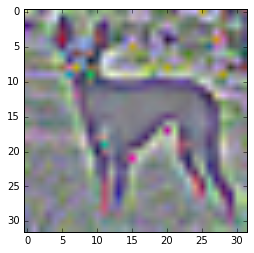

In [8]:
plt.figure()
plt.imshow(rgbArray)
plt.show()

In [9]:
set(y_train['Prediction'])

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

## SVM implementation
We consider the problem by its dual

In [10]:
(N,D)=rgbArray[:,:,1].shape

In [11]:
y = np.array([1, -1, 1, -1])

In [12]:
X = np.array([[1, 2, 3, 4], [5, 6, 7, 8]])

In [5]:
def dual_objective_function(y,X,x):
    return sum(x)-0.5*np.linalg.norm(sum(np.multiply(x,np.multiply(y,X)).T))**2

def transform_svm_dual( C, X, y ):
    
    (d, n) = X.shape
    M = (y*X);
    Q = M.T.dot(M)
    p = -np.ones(n)
    b = np.zeros(2*n)
    b[:n] = C
    A = np.zeros((2*n , n))
    A[:n , :n] = np.eye(n)
    A[n:, :n] = -np.eye(n)

    return Q,p,A,b

def transform_svm_primal(C,X,y):
    
    [d, n] = X.shape

    Q = np.zeros((d+n, d+n))
    p = C*np.ones(d+n)
    for k in range(d):
        Q[k,k]=1
        p[k] = 0

    A = np.zeros((2*n, d+n))
    A[:n,:d] = np.multiply(y,X).T
    A[:n, d:] = np.eye(n)
    A[n:, d:] = np.eye(n)
    A=-A

    b = np.zeros(2*n)
    b[:n]=-np.ones(n)
    
    return Q, p, A, b

def f1(x, t):
    B=0
    for i in range(A.shape[0]):
        B = B -np.log(b[i]-A[i,:].dot(x))
    return t*0.5*(x.T).dot(Q.dot(x))+t*(p).dot(x)+B

def grad_f1(x, t):
    c = np.zeros(A.shape[0]);
    for i in range(len(c)):
        c[i] = 1/(b[i]-A[i,:].dot(x))

    return t*Q.T.dot(x) + t*p + A.T.dot(c)


def hess_f1(x, t):

    c = np.zeros(A.shape[0]);
    for i in range(len(c)):
        c[i] = 1/(b[i]-A[i,:].dot(x))

    M1 = np.zeros((A.shape[1], A.shape[1]))
    for i in range(len(c)):
        M1 = M1 + A[[i], :].T.dot(A[[i], :])/(b[i]-A[i,:].dot(x))

    return t*Q + M1


def Newton(t,x, grad_f1, hess_f1, f1):
    beta = 0.5
    alpha = 0.25
    
    delta_x = -np.linalg.inv(hess_f1(x,t)).dot(grad_f1(x, t))
    lambda1 = np.sqrt(grad_f1(x, t).T.dot(np.linalg.inv(hess_f1(x,t)).dot(grad_f1(x, t))))

    #Backtracking line search
    step = 1

    while (np.isnan(f1(x+step*delta_x, t))) or (f1(x+step*delta_x, t) >= f1(x, t)+alpha*step*grad_f1(x, t).T.dot(delta_x)):
        step = beta*step

    x_new = x+step*delta_x
    gap = lambda1**2/2
    #value_function.append(dual_objective_function(y,X,x_new))
    
    return x_new, gap

def centering_step(Q,p,A,b,x,t,tol):

    gap = np.inf
    
    while gap > tol:
        [x_new, gap] = Newton(t,x, grad_f1, hess_f1, f1)
        x = x_new

    return x

def barr_method(Q,p,A,b,x_0,mu,tol):

    x = x_0
    m = A.shape[0]
    t=1

    while m/t >= tol:
        x = centering_step(Q,p,A,b,x,t,tol)
        t = mu*t
    return x

def SVM_classifier(X, y, primal=True):
    if primal:
        global Q, p, A, b
        Q, p, A, b = transform_svm_primal( C, X, y)
        d = X.shape[0]
        x_0 = np.zeros(A.shape[1])
        x_0[d:] = 2
    else:
        Q, p, A, b = transform_svm_dual( C, X, y)
        x_0 = 0.5*np.ones(A.shape[1])
    
    x = barr_method(Q,p,A,b,x_0,mu,tol)
    y_pred = X.T.dot(x[:d])
    
    return y_pred

def train_one_versus_all_logistic_classifier(features, labels, classifier = 'LR'):
    N = len(labels)
    n_labels = len(set(labels))
    alphas = np.zeros((n_labels, N))
    for label in range(n_labels):
        one_versus_all_labels = np.zeros(N)
        for i in range(N):
            if labels[i] == label:
                one_versus_all_labels[i] = 1
            else:
                one_versus_all_labels[i] = -1
        if classifier == 'LR':
            alphas[label, :] = logistic_regression_classifier(features, one_versus_all_labels)
        elif classifier == 'SVM':
            alphas[label, :] = SVM_classifier(features, one_versus_all_labels)
        print "classifier for label ", label, " done"
    return alphas

## Test on toy synthetic data

In [19]:
X = np.array([[1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
[-0.8664, -3.4678, -1.6305, -4.6784, -2.6387, -1.3149, 2.9648, 1.3490, 1.6594, 3.5194, 3.3673, 2.4726],
[-3.9723, -2.8689, -0.5480, -4.1768, -4.6656, -1.5996, 3.3436, 3.8466, 1.9035, 2.5204, 1.9115, 5.0098]])

In [20]:
y = np.array([1,1,1,1,1,1,-1,-1,-1,-1,-1,-1])

In [6]:
n_samples = 30
mean_1 = [0, -3]
cov = [[3, 0], [0, 3]]
X_1 = np.random.multivariate_normal(mean_1, cov, n_samples).T
mean_2 = [0, 3]
X_2 = np.random.multivariate_normal(mean_2, cov, n_samples).T
X = np.concatenate((X_1, X_2), axis = 1)
X = np.concatenate((np.ones((1, 2*n_samples)), X), axis=0)

y = np.concatenate((np.ones((1,n_samples)), -np.ones((1, n_samples))), axis=1)
y = y[0,:]

In [7]:
C = 1
tol = 0.5
mu = 2
t =1

In [8]:
primal = True
if primal:
    Q, p, A, b = transform_svm_primal( C, X, y)
    d = X.shape[0]
    x_0 = np.zeros(A.shape[1])
    x_0[d:] = 2
else:
    Q, p, A, b = transform_svm_dual( C, X, y)
    x_0 = 0.5*np.ones(A.shape[1])


In [9]:
value_function = []
x = barr_method(Q,p,A,b,x_0,mu,tol)

/Users/christophelanternier/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:42: RuntimeWarning: invalid value encountered in log


In [10]:
x_line = range(-10,10)
y_line = np.multiply(-x[1]/x[2],x_line) - x[0]/x[2]

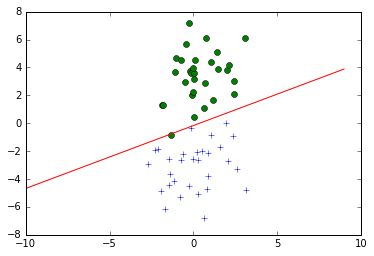

In [11]:
plt.figure()
plt.plot(X[1:, y>0][0,:], X[1:, y>0][1,:], '+')
plt.plot(X[1:, y<0][0,:], X[1:, y<0][1,:], 'o')
plt.plot(x_line, y_line)
plt.show()

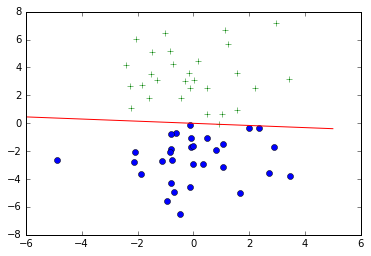

In [664]:
y_pred = X.T.dot(x[:3])
plt.figure()
plt.plot(X[1:, y_pred>0][0,:], X[1:, y_pred>0][1,:], 'o')
plt.plot(X[1:, y_pred<0][0,:], X[1:, y_pred<0][1,:], '+')
plt.plot(x_line, y_line)
plt.show()

# Multilabel SVM test

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from classification import *

In [3]:
C = 1
tol = 0.5
mu = 2
t =1

In [4]:
n_samples = 30
mean_1 = [0, -3]
cov = [[3, 0], [0, 3]]
X_1 = np.random.multivariate_normal(mean_1, cov, n_samples).T
mean_2 = [3, 3]
X_2 = np.random.multivariate_normal(mean_2, cov, n_samples).T
mean_3 = [-3, 3]
X_3 = np.random.multivariate_normal(mean_3, cov, n_samples).T
X = np.concatenate((X_1, X_2, X_3), axis = 1)
X = np.concatenate((np.ones((1, 3*n_samples)), X), axis=0)

y = np.concatenate((np.zeros((1,n_samples)), np.ones((1, n_samples)), 2*np.ones((1,n_samples))), axis=1)
y = y[0,:]

In [5]:
pred = train_one_versus_all_logistic_classifier(X, y, classifier = 'SVM')

classification.py:171: RuntimeWarning: invalid value encountered in log
  B = B -np.log(b[i]-A[i,:].dot(x))


classifier for label  0  done
classifier for label  1  done
classifier for label  2  done


In [6]:
np.argmax(pred, axis=0)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 2, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 1, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

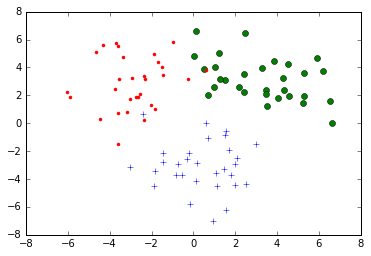

In [7]:
plt.figure()
plt.plot(X[1:, y==0][0,:], X[1:, y==0][1,:], '+')
plt.plot(X[1:, y==1][0,:], X[1:, y==1][1,:], 'o')
plt.plot(X[1:, y==2][0,:], X[1:, y==2][1,:], '.')
#plt.plot(x_line, y_line)
plt.show()

In [9]:
y

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  2.,  2.,  2.,  2.,  2.,
        2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,
        2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.])

In [8]:
plt.figure()
plt.plot(X[1:, pred==0][0,:], X[1:, pred==0][1,:], '+')
plt.plot(X[1:, pred==1][0,:], X[1:, pred==1][1,:], 'o')
plt.plot(X[1:, pred==2][0,:], X[1:, pred==2][1,:], '.')
#plt.plot(x_line, y_line)
plt.show()

IndexError: too many indices for array